In [1]:
import torch as tc
from torch import nn
from torch import optim
from matplotlib import pyplot as plt
tc.random.manual_seed(0)

### pytorch人工データ分類

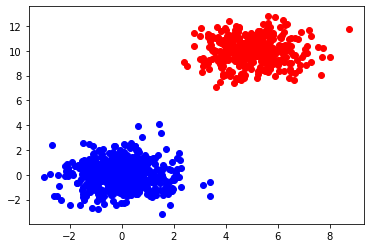

In [2]:
# データ
num0, num1 = 600, 400  # クラスター1, クラスター2のデータ数
x0, x1 = tc.randn(num0, 2), tc.randn(num1, 2) + tc.tensor([5, 10])
x = tc.cat([x0, x1])
y = tc.cat([tc.zeros(num0), tc.ones(num1)])
plt.scatter(x[y==0, 0], x[y==0, 1], color='b')
plt.scatter(x[y==1, 0], x[y==1, 1], color='r')

##### 線形モデルで分離

In [3]:
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.w = tc.nn.Parameter(tc.randn(2, 1))
        self.b = tc.nn.Parameter(tc.randn(1))
    
    def forward(self, x):
        return tc.mm(x, self.w) + self.b.unsqueeze(0)

In [4]:
model = LinearModel()
criterion = tc.nn.BCEWithLogitsLoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [7]:
for _ in range(1000):
    z = model(x)
    loss = criterion(z.squeeze(1), y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

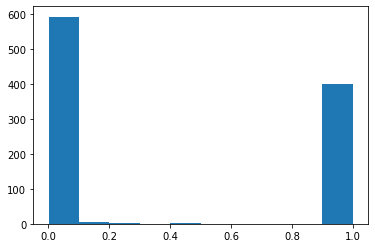

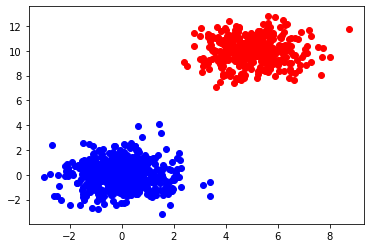

In [8]:
with tc.no_grad():
    Z = tc.sigmoid(model(x))[:, 0]
plt.hist(Z.numpy())
plt.show()

plt.scatter(x[Z<=0.5, 0], x[Z<=0.5, 1], color='b')
plt.scatter(x[Z>0.5, 0], x[Z>0.5, 1], color='r')

##### ２次元標準正規分布と、N([5, 10], 1)の２次元正規分布のテストデータで試す

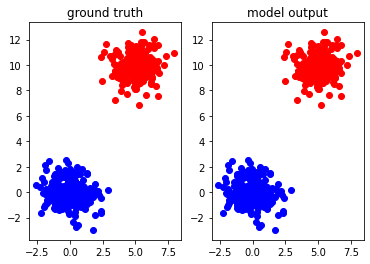

In [9]:
X0, X1 = tc.randn(200, 2), tc.randn(200, 2) + tc.tensor([5, 10])
X = tc.cat([X0, X1])
Y = tc.cat([tc.zeros(200), tc.ones(200)])
with tc.no_grad():
    Z = model(X).squeeze(1)

plt.subplot(1, 2, 1)
plt.title('ground truth')
plt.scatter(X[Y==0, 0], X[Y==0, 1], color='b')
plt.scatter(X[Y==1, 0], X[Y==1, 1], color='r')

plt.subplot(1, 2, 2)
plt.title('model output')
plt.scatter(X[Z<=0.5, 0], X[Z<=0.5, 1], color='b')
plt.scatter(X[Z>0.5, 0], X[Z>0.5, 1], color='r')
plt.show()

### DNNで線形分離不可能な問題を解く

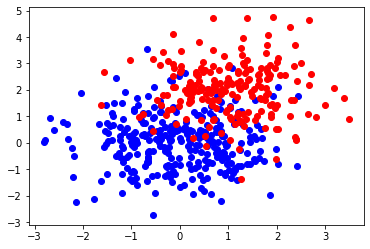

In [10]:
# データ
num0, num1 = 300, 200  # クラスター1, クラスター2のデータ数
x0, x1 = tc.randn(num0, 2), tc.randn(num1, 2) + tc.tensor([1, 2])
x = tc.cat([x0, x1])
y = tc.cat([tc.zeros(num0), tc.ones(num1)])
plt.scatter(x[y==0, 0], x[y==0, 1], color='b')
plt.scatter(x[y==1, 0], x[y==1, 1], color='r')

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.affine1 = nn.Linear(2, 100)
        self.affine2 = nn.Linear(100, 20)
        self.affine3 = nn.Linear(20, 1)
    
    def forward(self, x):
        x = tc.sigmoid(self.affine1(x))
        x = tc.sigmoid(self.affine2(x))
        x = tc.sigmoid(self.affine3(x))
        return x

In [12]:
net = Net()
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.1)

In [13]:
for _ in range(1000):
    Z = net(x)
    loss = criterion(Z.squeeze(1), y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

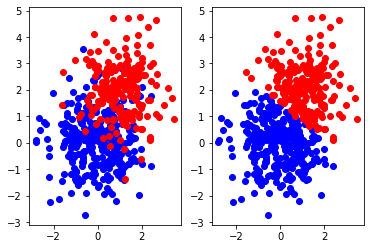

In [14]:
with tc.no_grad():
    Z = net(x).squeeze(1)

plt.subplot(1, 2, 1)
plt.scatter(x[y==0, 0], x[y==0, 1], color='b')
plt.scatter(x[y==1, 0], x[y==1, 1], color='r')


plt.subplot(1, 2, 2)
plt.scatter(x[Z<=0.5, 0], x[Z<=0.5, 1], color='b')
plt.scatter(x[Z>0.5, 0], x[Z>0.5, 1], color='r')
plt.show()

### CNNでMNIST(0, 1)分類

In [15]:
import torchvision as tv
from torchvision import transforms
from torchvision import datasets as d
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

device = tc.device('cuda:0')
device

device(type='cuda', index=0)

In [16]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1,))])
whole_trainset = d.MNIST(root='./data', train=True, download=True, transform=transform)
train_mask = tc.cat([(whole_trainset.targets == 0).nonzero()[:, 0], (whole_trainset.targets == 1).nonzero()[:, 0]])
trainset = Subset(whole_trainset, train_mask)

whole_testset = d.MNIST(root='./data', train=False, download=True, transform=transform)
test_mask  = tc.cat([(whole_testset.targets == 0).nonzero()[:, 0], (whole_testset.targets == 1).nonzero()[:, 0]])
testset = Subset(whole_testset, test_mask)

In [17]:
len(trainset)

12665

In [18]:
trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

In [60]:
from torch.nn import functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.affine1 = nn.Linear(16*4*4, 120)
        self.affine2 = nn.Linear(120, 84)
        self.affine3 = nn.Linear(84, 2)
    
    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = x.view(-1, 16*4*4)
        x = F.relu(self.affine1(x))
        x = F.relu(self.affine2(x))
        return self.affine3(x)

In [64]:
model = ConvNet()
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [65]:
for epoch in range(1):
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        images, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        preds = model(images)
        labels = F.one_hot(labels, num_classes=2).to(tc.float32)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 1000 == 999:
            print('%d, %5d loss: %.3f' % (epoch + 1, i + 1, running_loss/1000))
            running_loss = 0.0

1,  1000 loss: 0.038
1,  2000 loss: 0.007
1,  3000 loss: 0.005


In [66]:
correct = 0
total = 0
with tc.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = tc.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [67]:
print('Accuracy: %d %%' % (100 * correct / total))

Accuracy: 99 %


In [70]:
test = iter(testloader).next()
images, labels = test[0].to(device), test[1].to(device)
_, preds = tc.max(model(images), 1)
for i in range(4):
    print('pred: %d, target: %d' % (preds[i], labels[i]))

pred: 0, target: 0
pred: 0, target: 0
pred: 0, target: 0
pred: 0, target: 0
